In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
import pylab as py
import random
import pandas as pd
from matplotlib import gridspec
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from datetime import datetime
import time
import corner
import emcee
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
from ltsfit.lts_linefit import lts_linefit

In [2]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax

In [3]:
Dist_i = pd.read_csv("MLratio_i_distances_noCorrection.csv", sep=',')

for col in Dist_i.columns:
    newcol = col.strip()
    Dist_i.rename(columns={col:newcol}, inplace=True)
Dist_i = Dist_i.set_index("PGC")

# Dist_i = Dist_i[["DM_75","DMi_fid"]]

Dist_i.head()

,DM_75,DMi_fid,Mass_HI,Ms_i,Mb,F21,eF21,Qs
PGC,,,,,,,,
4,34.011709,33.411845,1.806150e+09,2.602457e+09,5.004637e+09,1.905,0.07,5.0
16,34.491034,34.646527,1.754429e+09,2.405546e+10,2.638885e+10,1.190,0.20,5.0
55,34.167913,33.811232,4.707702e+09,2.271251e+09,8.532494e+09,4.300,0.32,5.0
68,35.108989,34.868603,4.193694e+09,1.157965e+10,1.715727e+10,1.610,0.27,5.0
70,34.900087,35.358661,1.790008e+10,4.021006e+10,6.401717e+10,8.330,0.12,5.0


In [4]:
df = pd.read_csv("MLratio_z_distances_noCorrection.csv", sep=',')

for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)
Dist_z = df.set_index("PGC")

# Dist_z = df[["DMz_fid"]]

Dist_z.head()

,DM_75,DMz_fid,Mass_HI,Ms_z,Mb,F21,eF21,Qs
PGC,,,,,,,,
4,34.011709,33.433917,1.806150e+09,2.531358e+09,4.933538e+09,1.905,0.07,5.0
16,34.491034,34.589261,1.754429e+09,2.546793e+10,2.780132e+10,1.190,0.20,5.0
55,34.167913,33.820304,4.707702e+09,2.249444e+09,8.510687e+09,4.300,0.32,5.0
68,35.108989,34.778487,4.193694e+09,1.278220e+10,1.835981e+10,1.610,0.27,5.0
70,34.900087,35.264078,1.790008e+10,4.492259e+10,6.872970e+10,8.330,0.12,5.0


In [5]:
df = pd.read_csv("MLratio_r_distances_noCorrection.csv", sep=',')

for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)
Dist_r = df.set_index("PGC")

# Dist_r = df[["DMr_fid"]]

Dist_r.head()

,DM_75,DMr_fid,Mass_HI,Ms_r,Mb,F21,eF21,Qs
PGC,,,,,,,,
4,34.011709,33.448800,1.806150e+09,2.484183e+09,4.886363e+09,1.905,0.07,5.0
16,34.491034,34.649781,1.754429e+09,2.379105e+10,2.612444e+10,1.190,0.20,5.0
55,34.167913,33.810436,4.707702e+09,2.278585e+09,8.539828e+09,4.300,0.32,5.0
68,35.108989,34.823019,4.193694e+09,1.210864e+10,1.768626e+10,1.610,0.27,5.0
70,34.900087,35.349855,1.790008e+10,4.004375e+10,6.385086e+10,8.330,0.12,5.0


In [6]:
df = pd.read_csv("MLratio_W1_distances_noCorrection.csv", sep=',')

for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)
Dist_W1 = df.set_index("PGC")

Dist_W1 = Dist_W1.rename(columns={'DMw1_fid':'DM1_fid'})

# Dist_W1 = Dist_W1[["DMw1_fid"]]

Dist_W1.head()

,DM_75,DM1_fid,Mass_HI,Ms_W1,Mb,F21,eF21,Qw
PGC,,,,,,,,
2,34.349020,34.487005,6.118492e+09,1.426708e+11,1.508084e+11,4.730,0.81,5.0
4,34.011709,33.712843,1.806150e+09,1.844431e+09,4.246611e+09,1.905,0.07,4.0
12,34.779466,34.984702,6.537934e+09,4.431121e+10,5.300666e+10,3.400,0.58,5.0
16,34.491034,34.658557,1.754429e+09,2.350395e+10,2.583734e+10,1.190,0.20,5.0
55,34.167913,33.945915,4.707702e+09,1.889488e+09,8.150731e+09,4.300,0.32,4.0


In [7]:
Dist_riz = pd.read_csv("MLratio_riz_distances_noCorrection.csv", sep=',')

for col in Dist_riz.columns:
    newcol = col.strip()
    Dist_riz.rename(columns={col:newcol}, inplace=True)
Dist_riz = Dist_riz.set_index("PGC")

# Dist_riz = Dist_riz[["DMriz_fid"]]

Dist_riz.head()

,DM_75,DMriz_fid,Mass_HI,Ms_riz,Mb,F21,eF21,Qs
PGC,,,,,,,,
4,34.011709,33.426808,1.806150e+09,2.530873e+09,4.933053e+09,1.905,0.07,5.0
16,34.491034,34.623880,1.754429e+09,2.427506e+10,2.660845e+10,1.190,0.20,5.0
55,34.167913,33.812618,4.707702e+09,2.262864e+09,8.524107e+09,4.300,0.32,5.0
68,35.108989,34.817386,4.193694e+09,1.211590e+10,1.769351e+10,1.610,0.27,5.0
70,34.900087,35.321309,1.790008e+10,4.146816e+10,6.527527e+10,8.330,0.12,5.0


In [8]:
# df = pd.read_csv("btfr_brent_updated.csv", sep='|')

# for col in df.columns:
#     newcol = col.strip()
#     df.rename(columns={col:newcol}, inplace=True)
    
# df = df.set_index("PGC")   

# db = df[["Vls"]]

# db.head()

In [9]:
def lambada(X):
    
    if ~np.isnan(X[col+"_riz"]):
        return X[col+"_riz"]
    elif ~np.isnan(X[col+"_i"]):
        return X[col+"_i"]
    elif ~np.isnan(X[col+"_r"]):
        return X[col+"_r"]
    elif ~np.isnan(X[col+"_z"]):
        return X[col+"_z"]
    else:
        return X[col]

df = Dist_i.join(Dist_riz, how='left', lsuffix='_i', rsuffix='_riz')
df = df.join(Dist_r, how='left')
df = df.join(Dist_z, how='left', lsuffix='_r', rsuffix='_z')
df = df.join(Dist_W1, how='outer') # .join(db)

df['Qs'] = df['Qs_i']
df['DM_75_w1'] = df['DM_75']

commons = ['DM_75', 'Mass_HI', 'Mb', 'F21', 'eF21', 'Qs']
for col in commons:
    df[col] = df.apply(lambada, axis=1)


df.head(10)

,DM_75_i,DMi_fid,Mass_HI_i,Ms_i,Mb_i,F21_i,eF21_i,Qs_i,DM_75_riz,DMriz_fid,...,DM_75,DM1_fid,Mass_HI,Ms_W1,Mb,F21,eF21,Qw,Qs,DM_75_w1
PGC,,,,,,,,,,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,34.349020,34.487005,6.118492e+09,1.426708e+11,1.508084e+11,4.730,0.81,5.0,NaN,34.349020
4,34.011709,33.411845,1.806150e+09,2.602457e+09,5.004637e+09,1.905,0.07,5.0,34.011709,33.426808,...,34.011709,33.712843,1.806150e+09,1.844431e+09,4.933053e+09,1.905,0.07,4.0,5.0,34.011709
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,34.779466,34.984702,6.537934e+09,4.431121e+10,5.300666e+10,3.400,0.58,5.0,NaN,34.779466
16,34.491034,34.646527,1.754429e+09,2.405546e+10,2.638885e+10,1.190,0.20,5.0,34.491034,34.623880,...,34.491034,34.658557,1.754429e+09,2.350395e+10,2.660845e+10,1.190,0.20,5.0,5.0,34.491034
55,34.167913,33.811232,4.707702e+09,2.271251e+09,8.532494e+09,4.300,0.32,5.0,34.167913,33.812618,...,34.167913,33.945915,4.707702e+09,1.889488e+09,8.524107e+09,4.300,0.32,4.0,5.0,34.167913
68,35.108989,34.868603,4.193694e+09,1.157965e+10,1.715727e+10,1.610,0.27,5.0,35.108989,34.817386,...,35.108989,34.701820,4.193694e+09,1.407284e+10,1.769351e+10,1.610,0.27,5.0,5.0,35.108989
70,34.900087,35.358661,1.790008e+10,4.021006e+10,6.401717e+10,8.330,0.12,5.0,34.900087,35.321309,...,34.900087,35.145457,1.790008e+10,4.909873e+10,6.527527e+10,8.330,0.12,5.0,5.0,34.900087
76,34.937682,34.747816,9.843772e+09,7.655490e+10,8.964712e+10,4.425,0.11,5.0,34.937682,34.724822,...,34.937682,34.829031,9.843772e+09,6.838351e+10,9.038038e+10,4.425,0.11,5.0,5.0,34.937682
92,34.390188,32.893854,5.078582e+09,4.164620e+09,1.091913e+10,3.780,0.08,5.0,34.390188,32.887306,...,34.390188,NaN,5.078582e+09,NaN,1.095090e+10,3.780,0.08,NaN,5.0,NaN


In [10]:
old = pd.read_csv("../calibrators/DMs_EDD.csv.test", sep='|')

for col in old.columns:
    newcol = col.strip()
    old.rename(columns={col:newcol}, inplace=True)
old = old.set_index("pgc")

# oldCols = ["P0", "ggg", "rrr", "iii", "zzz"]
# for col in oldCols:
#     old[col] = old[col].apply(lambda x: np.float(x))


df = df.join(old, how='left', lsuffix='_new', rsuffix='_old')

df.head()

,DM_75_i,DMi_fid,Mass_HI_i,Ms_i,Mb_i,F21_i,eF21_i,Qs_i,DM_75_riz,DMriz_fid,...,pgc1,Nest,Vmodg,Nkt,N15,sglg,sgbg,RS,P0,DM_src
PGC,,,,,,,,,,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,73150,200275,4976,0,7,341.4922,20.7395,2,2.02,2
4,34.011709,33.411845,1.806150e+09,2.602457e+09,5.004637e+09,1.905,0.07,5.0,34.011709,33.426808,...,120,202766,4154,0,0,316.0587,18.4514,2,-2.75,1
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12,210177,6279,0,1,286.4249,11.3510,2,0.56,2
16,34.491034,34.646527,1.754429e+09,2.405546e+10,2.638885e+10,1.190,0.20,5.0,34.491034,34.623880,...,16,211419,5434,0,1,287.6120,11.7030,2,0.92,1
55,34.167913,33.811232,4.707702e+09,2.271251e+09,8.532494e+09,4.300,0.32,5.0,34.167913,33.812618,...,55,0,4507,0,0,327.0996,19.7763,2,-2.83,1


In [11]:
df.columns

Index(['DM_75_i', 'DMi_fid', 'Mass_HI_i', 'Ms_i', 'Mb_i', 'F21_i', 'eF21_i',
       'Qs_i', 'DM_75_riz', 'DMriz_fid', 'Mass_HI_riz', 'Ms_riz', 'Mb_riz',
       'F21_riz', 'eF21_riz', 'Qs_riz', 'DM_75_r', 'DMr_fid', 'Mass_HI_r',
       'Ms_r', 'Mb_r', 'F21_r', 'eF21_r', 'Qs_r', 'DM_75_z', 'DMz_fid',
       'Mass_HI_z', 'Ms_z', 'Mb_z', 'F21_z', 'eF21_z', 'Qs_z', 'DM_75',
       'DM1_fid', 'Mass_HI', 'Ms_W1', 'Mb', 'F21', 'eF21', 'Qw', 'Qs',
       'DM_75_w1', 'Vh', 'Vls', 'V3k', 'Vmod', 'f_cosmology', 'logWimx',
       'logWimx_e', 'inc', 'Sqlt', 'Wqlt', 'DM_best', 'dDM_best', 'DMr',
       'dDMr', 'RMS_r', 'DMr_raw', 'DMi', 'dDMi', 'RMS_i', 'DMi_raw', 'DMz',
       'dDMz', 'RMS_z', 'DMz_raw', 'DM_w1', 'dDM_w1', 'RMS_w1', 'DMw1_raw',
       'ggg', 'rrr', 'iii', 'zzz', 'w1', 'w2', 'RA', 'DEC', 'gl', 'gb', 'sgl',
       'sgb', 'pgc1', 'Nest', 'Vmodg', 'Nkt', 'N15', 'sglg', 'sgbg', 'RS',
       'P0', 'DM_src'],
      dtype='object')

In [12]:
len(df)

10154

In [13]:
df['logMs_riz'] = np.log10(df.Ms_riz)
df['logMs_r'] = np.log10(df.Ms_r)
df['logMs_i'] = np.log10(df.Ms_i)
df['logMs_z'] = np.log10(df.Ms_z)
df['logMs_W1'] = np.log10(df.Ms_W1)

In [14]:
df[['DMr_fid', 'DMi_fid', 'DMz_fid', 'DMriz_fid', 'DM1_fid']]

,DMr_fid,DMi_fid,DMz_fid,DMriz_fid,DM1_fid
PGC,,,,,
2,NaN,NaN,NaN,NaN,34.487005
4,33.448800,33.411845,33.433917,33.426808,33.712843
12,NaN,NaN,NaN,NaN,34.984702
16,34.649781,34.646527,34.589261,34.623880,34.658557
55,33.810436,33.811232,33.820304,33.812618,33.945915
...,...,...,...,...,...
5953001,33.326997,33.327252,33.265175,33.300332,NaN
6657028,32.064503,32.059220,32.062919,32.058108,NaN
6719321,31.757698,31.752950,31.772209,31.755497,NaN


In [15]:
import copy 

df_paper = copy.deepcopy(df)

# M_gas = 1.33 x M_HI = 1.33 x 2.36X10^5 x (3950/75)^2 x 69.07   => log Mgass = 10.78 not 7.851
df_paper['flag'] = 1
adhi_list = [5072, 9670, 49734, 51401, 1737674, 3091777, 5807477]
df_paper.loc[adhi_list]['flag'] = 0

df_paper['DM_av'] = df_paper[['DMriz_fid', 'DM1_fid']].mean(axis=1)


indx = (df_paper.Qs<3) & (df_paper.Qw>=3)
df_paper['DM_av'][indx] = df_paper['DM1_fid'][indx]

indx = (df_paper.Qs>=3) & (df_paper.Qw<3)
df_paper['DM_av'][indx] = df_paper['DMriz_fid'][indx]

df_paper['Dav'] = 10**((df_paper.DM_av-25)/5.)

df_paper['DM_75'] = df_paper[['DM_75_riz', 'DM_75_w1']].mean(axis=1)
df_paper['D75'] = 10**((df_paper.DM_75-25)/5.)

df_paper['logMs'] = df_paper[['logMs_riz', 'logMs_W1']].mean(axis=1)
df_paper['Ms'] = 10**df_paper.logMs

df_paper['Mass_HI'] = 2.356E5 * df_paper.F21 * (df_paper.D75**2)

df_paper['logMgas'] = np.log10(1.33*(10**(np.log10(df_paper.Mass_HI))))
df_paper['Mgas'] = 1.33*(10**(np.log10(df_paper.Mass_HI)))

df_paper['Mb'] = df_paper.Ms+df_paper.Mgas
df_paper['logMb'] = np.log10(df_paper.Mb)



old = pd.read_csv("../calibrators/corrected_mags_linewidth_all.csv", sep='|')
for col in old.columns:
    newcol = col.strip()
    old.rename(columns={col:newcol}, inplace=True)

old = old.set_index("pgc")

df_paper = df_paper.join(old[['inc_e']], how='left')


df_paper["DMriz_err"] = np.sqrt((0.02*(df_paper['logWimx']-2.5))**2 + \
            (3.418*df_paper['logWimx_e'])**2 + 0.04**2 + 0.05**2)/0.4 + 0.*df_paper.DMriz_fid

df_paper["DMr_err"] = np.sqrt((0.02*(df_paper['logWimx']-2.5))**2 + \
            (3.407*df_paper['logWimx_e'])**2 + 0.040**2 + 0.05**2)/0.4 + 0.*df_paper.DMr_fid 

df_paper["DMi_err"] = np.sqrt((0.02*(df_paper['logWimx']-2.5))**2 + \
            (3.421*df_paper['logWimx_e'])**2 + 0.040**2 + 0.05**2)/0.4 + 0.*df_paper.DMi_fid 

df_paper["DMz_err"] = np.sqrt((0.02*(df_paper['logWimx']-2.5))**2 + \
            (3.424*df_paper['logWimx_e'])**2 + 0.040**2 + 0.05**2)/0.4 + 0.*df_paper.DMz_fid 

df_paper["DM1_err"] = np.sqrt((0.02*(df_paper['logWimx']-2.5))**2 + \
            (3.338*df_paper['logWimx_e'])**2 + 0.030**2 + 0.05**2)/0.4 + 0.*df_paper.DM1_fid 


df_paper['eDM'] = np.nanmax(df_paper[["DMriz_err","DM1_err"]], axis=1)


cols = ["flag", "DM_av", "eDM", "DMriz_fid", "DMriz_err"]
cols += ["DMr_fid", "DMr_err"]
cols += ["DMi_fid", "DMi_err"]
cols += ["DMz_fid", "DMz_err"]
cols += ["DM1_fid", "DM1_err"]
cols += ["DM_75", 'pgc1', 'Nest']
cols += ['logMs_riz', 'logMs_r', 'logMs_i', 'logMs_z', 'logMs_W1']
cols += ['logMgas', 'logMb']
cols += ['Vh', 'Vls', 'V3k', 'Vmod', 'f_cosmology']
cols += ['logWimx', 'logWimx_e', 'F21', 'eF21', 'inc', 'inc_e']
cols += ['ggg', 'rrr', 'iii', 'zzz', 'w1']
cols += ['Qs', 'Qw']
cols += ['RA', 'DEC', 'gl', 'gb', 'sgl', 'sgb', 'Nkt', 'N15', 'sglg', 'sgbg', 'Vmodg']

df_paper = df_paper[cols]


# df_paper = df_paper.rename(columns={"V3k_old":"V3k"})
# df_paper = df_paper.rename(columns={"Vmod_old":"Vmod"})

df_paper.ggg[df_paper.ggg.astype(np.float64)<=0]=-1000000
df_paper.rrr[df_paper.rrr.astype(np.float64)<=0]=-1000000
df_paper.iii[df_paper.iii.astype(np.float64)<=0]=-1000000
df_paper.zzz[df_paper.zzz.astype(np.float64)<=0]=-1000000
df_paper.w1[df_paper.w1.astype(np.float64)<=0]=-1000000


df_paper.head()

<ipython-input-15-4d2136725212>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paper['DM_av'][indx] = df_paper['DM1_fid'][indx]
<ipython-input-15-4d2136725212>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paper['DM_av'][indx] = df_paper['DMriz_fid'][indx]
/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ehsan/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,45,46,47,48,49

,flag,DM_av,eDM,DMriz_fid,DMriz_err,DMr_fid,DMr_err,DMi_fid,DMi_err,DMz_fid,...,DEC,gl,gb,sgl,sgb,Nkt,N15,sglg,sgbg,Vmodg
PGC,,,,,,,,,,,,,,,,,,,,,
2,1,34.487005,0.282781,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,47.2745,113.9553,-14.6992,341.6440,20.7388,0,7,341.4922,20.7395,4976
4,1,33.569826,0.200445,33.426808,0.200445,33.448800,0.200215,33.411845,0.200508,33.433917,...,23.0876,107.8322,-38.2729,316.0587,18.4514,0,0,316.0587,18.4514,4154
12,1,34.984702,0.228011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-6.3739,90.1920,-65.9300,286.4249,11.3511,0,1,286.4249,11.3510,6279
16,1,34.641219,0.266948,34.623880,0.266948,34.649781,0.266398,34.646527,0.267098,34.589261,...,-5.1587,91.6005,-64.8656,287.6119,11.7030,0,1,287.6120,11.7030,5434
55,1,33.879267,0.267216,33.812618,0.267216,33.810436,0.266667,33.811232,0.267366,33.820304,...,33.6009,110.9496,-28.0857,327.0996,19.7763,0,0,327.0996,19.7763,4507


In [16]:
df_paper.loc.__setitem__((90661, ('DM1_fid')), np.nan)
df_paper.loc.__setitem__((90661, ('DM1_err')), np.nan)

df_paper.loc.__setitem__((90661, ('DM_av')), df_paper.loc[90661]['DMriz_fid'])

# df_paper.loc[90661]

In [17]:
tfr4 = pd.read_csv("EDD_CF4_TF.csv", sep='|')

for col in df.columns:
    newcol = col.strip()
    tfr4.rename(columns={col:newcol}, inplace=True)

tfr4 = tfr4.set_index("PGC")
tfr4 = tfr4[["PGC1", "Nest"]]

df_paper = df_paper.join(tfr4, how='left', lsuffix='_new', rsuffix='_old')

In [18]:
df_paper.head()

,flag,DM_av,eDM,DMriz_fid,DMriz_err,DMr_fid,DMr_err,DMi_fid,DMi_err,DMz_fid,...,gb,sgl,sgb,Nkt,N15,sglg,sgbg,Vmodg,PGC1,Nest_old
PGC,,,,,,,,,,,,,,,,,,,,,
2,1,34.487005,0.282781,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-14.6992,341.6440,20.7388,0,7,341.4922,20.7395,4976,73150.0,200275.0
4,1,33.569826,0.200445,33.426808,0.200445,33.448800,0.200215,33.411845,0.200508,33.433917,...,-38.2729,316.0587,18.4514,0,0,316.0587,18.4514,4154,120.0,202766.0
12,1,34.984702,0.228011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-65.9300,286.4249,11.3511,0,1,286.4249,11.3510,6279,12.0,210177.0
16,1,34.641219,0.266948,34.623880,0.266948,34.649781,0.266398,34.646527,0.267098,34.589261,...,-64.8656,287.6119,11.7030,0,1,287.6120,11.7030,5434,16.0,211419.0
55,1,33.879267,0.267216,33.812618,0.267216,33.810436,0.266667,33.811232,0.267366,33.820304,...,-28.0857,327.0996,19.7763,0,0,327.0996,19.7763,4507,55.0,0.0


In [19]:
df_paper = df_paper.reset_index()

In [20]:
df_paper['pgc1_'] = df_paper.apply(lambda X: X.PGC1 if X.PGC1>0 else X.pgc1, axis=1)
df_paper['Nest_'] = df_paper.apply(lambda X: X.Nest_old if X.Nest_old>0 else X.Nest_new, axis=1)

In [21]:
df_paper['pgc1'] = df_paper['pgc1_']
df_paper['Nest_new'] = df_paper['Nest_']

df_paper = df_paper.drop(["Nest_old", "PGC1"], axis=1)
df_paper = df_paper.drop(["pgc1_", "Nest_"], axis=1)

df_paper = df_paper.rename(columns={"pgc1":"PGC1"})
df_paper = df_paper.rename(columns={"Nest_new":"Nest"})

df_paper.Nest[df_paper.Nest.astype(np.float64)<=0]=-1000000
df_paper.PGC1[df_paper.PGC1.astype(np.float64)<=0]=-1000000

<ipython-input-21-ce040b2d39f6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paper.Nest[df_paper.Nest.astype(np.float64)<=0]=-1000000
<ipython-input-21-ce040b2d39f6>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paper.PGC1[df_paper.PGC1.astype(np.float64)<=0]=-1000000


In [22]:
flags = pd.read_csv("BTFR_flags.csv", sep='|')
flags = flags[['PGC', 'flag']]
flags = flags.set_index('PGC')

try:
    df_paper = df_paper.set_index('PGC')
except:
    pass



df_paper = df_paper.join(flags, how='left', lsuffix='_l', rsuffix='_r')

df_paper['flag_l'] = df_paper['flag_r']
df_paper = df_paper.rename(columns={"flag_l":"flag"})
df_paper = df_paper.drop(columns=['flag_r'])

df_paper['flag'][((df_paper.DMriz_err>0.8) | (df_paper.DM1_err>0.8))] = 0

<ipython-input-22-898bd6590691>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paper['flag'][((df_paper.DMriz_err>0.8) | (df_paper.DM1_err>0.8))] = 0


In [23]:
print(df_paper.columns)
len(df_paper)

Index(['flag', 'DM_av', 'eDM', 'DMriz_fid', 'DMriz_err', 'DMr_fid', 'DMr_err',
       'DMi_fid', 'DMi_err', 'DMz_fid', 'DMz_err', 'DM1_fid', 'DM1_err',
       'DM_75', 'PGC1', 'Nest', 'logMs_riz', 'logMs_r', 'logMs_i', 'logMs_z',
       'logMs_W1', 'logMgas', 'logMb', 'Vh', 'Vls', 'V3k', 'Vmod',
       'f_cosmology', 'logWimx', 'logWimx_e', 'F21', 'eF21', 'inc', 'inc_e',
       'ggg', 'rrr', 'iii', 'zzz', 'w1', 'Qs', 'Qw', 'RA', 'DEC', 'gl', 'gb',
       'sgl', 'sgb', 'Nkt', 'N15', 'sglg', 'sgbg', 'Vmodg'],
      dtype='object')


10154

In [24]:
df_brent = pd.read_csv("btfr_brent_updated.csv", sep='|')
for col in df_brent.columns:
    newcol = col.strip()
    df_brent.rename(columns={col:newcol}, inplace=True)
df_brent = df_brent.set_index("PGC")
df_brent = df_brent[['Vhel', 'Vls', 'v3k', 'f', 'Vhg', 'Vlsg', 'V3kg', 'fg']]

df_paper_ = df_paper.join(df_brent, how='inner', lsuffix='_org', rsuffix='_brt')

df_paper_['f_cosmology'] = df_paper_.f
df_paper_['Vh'] = df_paper_.Vhel
df_paper_['Vls_org'] = df_paper_.Vls_brt
df_paper_['V3k'] = df_paper_.v3k


df_paper_ = df_paper_.drop(["f", "Vhel", "Vls_brt", "v3k","Vmodg","Vmod"], axis=1)
df_paper_ = df_paper_.rename(columns={"Vls_org":"Vls"})


df_paper_ = df_paper_.reset_index()

df_paper_.to_csv('BTFR_CF4_Dist_bar.MLratio.csv', sep='|', index=False)

print(df_paper_.columns)

len(df_paper_)

Index(['PGC', 'flag', 'DM_av', 'eDM', 'DMriz_fid', 'DMriz_err', 'DMr_fid',
       'DMr_err', 'DMi_fid', 'DMi_err', 'DMz_fid', 'DMz_err', 'DM1_fid',
       'DM1_err', 'DM_75', 'PGC1', 'Nest', 'logMs_riz', 'logMs_r', 'logMs_i',
       'logMs_z', 'logMs_W1', 'logMgas', 'logMb', 'Vh', 'Vls', 'V3k',
       'f_cosmology', 'logWimx', 'logWimx_e', 'F21', 'eF21', 'inc', 'inc_e',
       'ggg', 'rrr', 'iii', 'zzz', 'w1', 'Qs', 'Qw', 'RA', 'DEC', 'gl', 'gb',
       'sgl', 'sgb', 'Nkt', 'N15', 'sglg', 'sgbg', 'Vhg', 'Vlsg', 'V3kg',
       'fg'],
      dtype='object')


10154

In [25]:
len(df_paper_.columns)

55

In [26]:
from astropy.table import Table, Column

table   = np.genfromtxt('BTFR_CF4_Dist_bar.MLratio.csv' , delimiter='|', 
                        filling_values=-1000000, names=True, dtype=None, encoding=None)

colnames = table.dtype.names

## table is a structured array
myTable = {}
for name in table.dtype.names:
    myTable[name] = table[name]
table = myTable
## table is now a dictionary

myTable = Table()

for key in colnames:
    if key in ["pgc", "PGC"]:
        myTable.add_column(Column(data=table[key], name=key))
    elif key in ["f_cosmology",'logMs_riz','logMs_r','logMs_i','logMs_z','logMs_W1','logMgas','logMb','logWimx','logWimx_e', 'fg']:
        myTable.add_column(Column(data=table[key], name=key, format='%0.3f'))    
    elif key in ["Vh", "Vls", 'V3k', 'Vmod', 'Vmodg', 'inc', 
                 'Qs', 'Qw', 'Nkt', 'N15', '1PGC', 'Nest', 'flag', 'Vhg', 'Vlsg', 'V3kg']:
        myTable.add_column(Column(data=table[key], name=key, dtype=np.dtype(int)))
    elif key in ['RA', 'DEC', 'gl', 'gb', 'sgl', 'sgb', 'sglg', 'sgbg']:
        myTable.add_column(Column(data=table[key], name=key, format='%0.4f'))      
    else:
        myTable.add_column(Column(data=table[key], name=key, format='%0.2f'))

## to be used on EDD
myTable.write('BTFR_CF4_Dist_bar_MLratio', format='ascii.fixed_width',delimiter='|', bookend=False, overwrite=True)

In [27]:
DM_W1 = df["DM1_fid"].values
DM_r = df["DMr_fid"].values
DM_i = df["DMi_fid"].values
DM_z = df["DMz_fid"].values
DM_riz = df["DMriz_fid"].values
DM_75 = df["DM_75"].values
Vls = df["Vls"].values

<ipython-input-28-7ab1e53bcd89>:12: RuntimeWarning: invalid value encountered in greater
  X = X[Y>-100]
<ipython-input-28-7ab1e53bcd89>:13: RuntimeWarning: invalid value encountered in greater
  Y = Y[Y>-100]


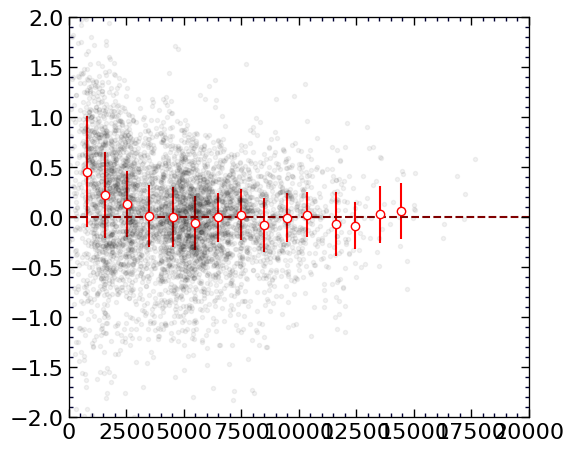

In [28]:
fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

ax.plot(Vls, DM_W1-DM_75, 'k.', alpha=0.05)

X = Vls
Y = DM_W1-DM_75
# Z = Vls

X = X[Y>-100]
Y = Y[Y>-100]

# X = X[np.abs(Z)>4000]
# Y = Y[np.abs(Z)>4000]
# Z = Z[np.abs(Z)>4000]

# X = X[np.abs(Y)<2]
# Z = Z[np.abs(Y)<2]
# Y = Y[np.abs(Y)<2]

for i in np.arange(0,20000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        
        xp = np.asarray(xp)
        yp = np.asarray(yp)
        
        Q1 = np.quantile(yp, 0.1)
        Q3 = np.quantile(yp, 0.9)
        
        xp = xp[((yp>Q1)&(yp<Q3))]
        yp = yp[((yp>Q1)&(yp<Q3))]
              
        if len(xp)>5:
            
            x  = np.median(xp)
            y  = np.median(yp)
            yerr = np.std(yp)

            ax.errorbar(x, y, yerr=yerr, fmt='o', 
                    color='red', ms=6, mfc='white') 
            
set_axes(ax, (0,20000), (-2,2))
ax.plot([0, 20000],[0,0], '--', color='maroon')


In [29]:
np.mean(Y)

0.030174946267050685

In [30]:
cf3 = pd.read_csv("../calibrators/cf3.csv", sep='|')

for col in cf3.columns:
    newcol = col.strip()
    cf3.rename(columns={col:newcol}, inplace=True)

cf3.set_index('PGC', inplace=True)

cf3['DM_cf3'] = cf3['DM']
cf3 = cf3[['DM_cf3']]

df34 = df_paper.join(cf3, how='inner')

/home/ehsan/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (5,7,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [31]:
def constant(x,delta):
    return delta

[-0.12681455] [[0.00067625]]
-0.05391463463459445 0.29652172389494175


Text(2500, -2, '$\\Delta =-0.054\\pm0.297$ [mag]')

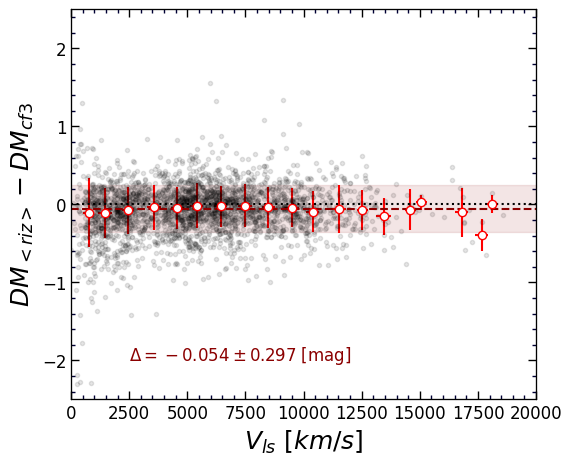

In [32]:
dff = df34[df34.Qs>2]

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff.Vls.values
Y = dff.DMriz_fid.values-dff.DM_cf3.values

Ye = np.sqrt(dff.DMriz_err.values**2+0.4**2)

fit, cov = curve_fit(constant, X, Y, sigma=Ye)
print(fit, cov)

ax.plot(X, Y, 'k.', alpha=0.1)

X = X[Y<1]
Y = Y[Y<1]

X = X[Y>-1.5]
Y = Y[Y>-1.5]

for i in np.arange(0,20000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6, mfc='white')   
        
ax.set_xlabel(r'$V_{ls} \/\/[km/s]$', fontsize=18) 
# ax.set_ylabel(r'$DM_{75} - DM_{fid}$', fontsize=18)
ax.set_ylabel(r'$DM_{<riz>}-DM_{cf3}$', fontsize=18)

ax.plot([0,20000], [0,0], ':', color='k')

set_axes(ax, (0,20000), (-2.5,2.5), fontsize=12)

# ax.set_title("BTFR: W1-band")

med = np.median(Y)
std = np.std(Y-med)
y = np.asarray([med,med])
ax.plot([0,20000], y, '--', color='darkred')
ax.fill_between([0,20000], y+std, y-std, color='darkred', alpha=0.10)

print(med,std)

ax.text(2500, -2, r"$\Delta =" + '%.3f'%med+'\pm'+'%.3f'%std+'$'+ ' [mag]', color='darkred', fontsize=12)

[-0.04370617] [[3.15559895e-05]]
-0.023465398734627385 0.2978424823897254


Text(2500, -2, '$\\Delta =-0.023\\pm0.298$ [mag]')

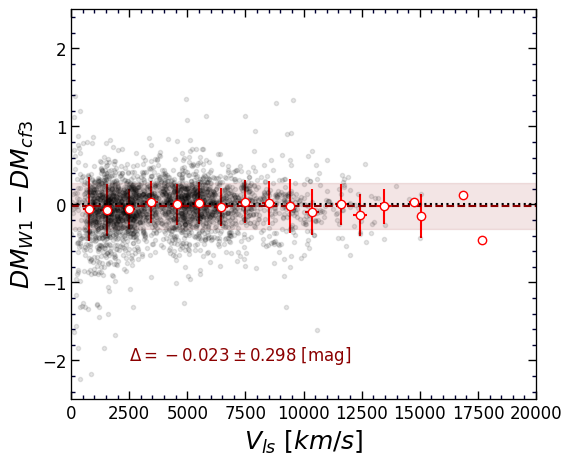

In [33]:
dff = df34[df34.Qw>2]

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff.Vls.values
Y = dff.DM1_fid.values-dff.DM_cf3.values

Ye = np.sqrt(dff.DM1_err.values**2+0.4**2)

fit, cov = curve_fit(constant, X, Y, sigma=Ye)
print(fit, cov)

ax.plot(X, Y, 'k.', alpha=0.1)

X = X[Y<1]
Y = Y[Y<1]

X = X[Y>-1.5]
Y = Y[Y>-1.5]

for i in np.arange(0,20000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6, mfc='white')   
        
ax.set_xlabel(r'$V_{ls} \/\/[km/s]$', fontsize=18) 
# ax.set_ylabel(r'$DM_{75} - DM_{fid}$', fontsize=18)
ax.set_ylabel(r'$DM_{W1}-DM_{cf3}$', fontsize=18)

ax.plot([0,20000], [0,0], ':', color='k')

set_axes(ax, (0,20000), (-2.5,2.5), fontsize=12)

# ax.set_title("BTFR: W1-band")

med = np.median(Y)
std = np.std(Y-med)
y = np.asarray([med,med])
ax.plot([0,20000], y, '--', color='darkred')
ax.fill_between([0,20000], y+std, y-std, color='darkred', alpha=0.10)

print(med,std)

ax.text(2500, -2, r"$\Delta =" + '%.3f'%med+'\pm'+'%.3f'%std+'$'+ ' [mag]', color='darkred', fontsize=12)

[-0.01625012] [[1.13930082e-05]]
-0.016250117626346094 0.13528462416428866


Text(2500, -0.6, '$\\Delta =-0.016\\pm0.135$ [mag]')

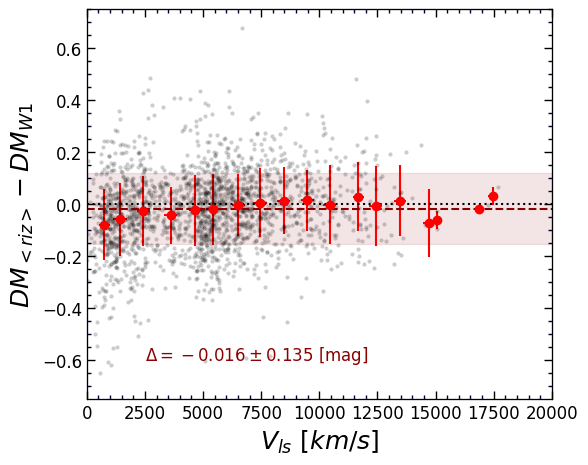

In [34]:
dff = df_paper[(df_paper.Qs>2)&(df_paper.Qw>3)].dropna() # 
# dff = df[(df.Qs>2)]

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff.Vls.values
Y = dff.DMriz_fid.values-dff.DM1_fid.values
Ye = np.sqrt(dff.DMriz_err.values**2+dff.DM1_err.values**2)

fit, cov = curve_fit(constant, X, Y, sigma=Ye)
print(fit, cov)

ax.plot(X, Y, 'k.', alpha=0.2, mfc='k', mec='none')

X = X[np.abs(Y)<0.40]
Y = Y[np.abs(Y)<0.40]


for i in np.arange(0,20000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
        
ax.set_xlabel(r'$V_{ls} \/\/[km/s]$', fontsize=18) 
# ax.set_ylabel(r'$DM_{75} - DM_{fid}$', fontsize=18)
ax.set_ylabel(r'$DM_{<riz>}-DM_{W1}$', fontsize=18)

ax.plot([0,20000], [0,0], ':', color='k')

set_axes(ax, (0,20000), (-.75,.75), fontsize=12)

# ax.set_title("BTFR: W1-band")

med = fit[0] #np.median(Y)
std = np.std(Y-fit[0])
y = np.asarray([med,med])
ax.plot([0,20000], y, '--', color='darkred')
ax.fill_between([0,20000], y+std, y-std, color='darkred', alpha=0.10)

print(med,std)

ax.text(2500, -0.6, r"$\Delta =" + '%.3f'%med+'\pm'+'%.3f'%std+'$'+ ' [mag]', color='darkred', fontsize=12)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f0566697790>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0566119850>)

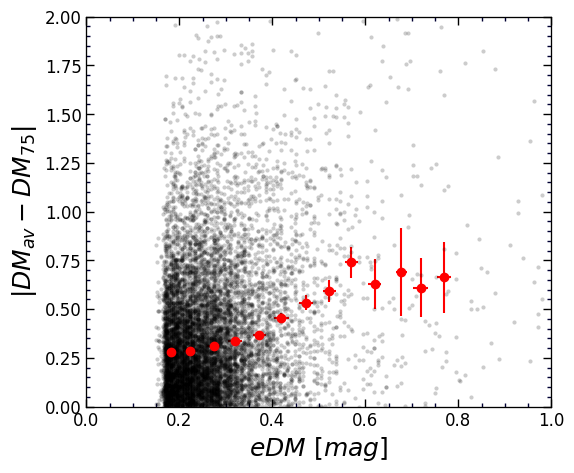

In [35]:
dff = df_paper[["DM_75", "DM_av", "eDM"]].dropna() # 
# dff = df[(df.Qs>2)]

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff.eDM.values
Y = np.abs(dff.DM_av.values - dff.DM_75.values)

ax.plot(X, Y, 'k.', alpha=0.2, mfc='k', mec='none')

# X = X[np.abs(Y)<0.40]
# Y = Y[np.abs(Y)<0.40]


for i in np.arange(0.15,0.8,0.05):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.05:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp)/np.sqrt(len(yp)), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
        
ax.set_ylabel(r'$|DM_{av} - DM_{75}|$', fontsize=18)
ax.set_xlabel(r'$eDM \/\/ [mag]$', fontsize=18)

# ax.plot([0,1], [0,0], ':', color='k')

set_axes(ax, (0,1), (0,2), fontsize=12)

